# Imports

In [1]:
# import matplotlib for plots
import matplotlib.pyplot as plt

# import numpy for arrays
import numpy as np

# import pandas for reading data
import pandas as pd

# import sklearn for preprocessing data
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import ShuffleSplit

# import from sklearn the linear regressor
from sklearn.linear_model import LinearRegression

# import mae as metrics
from sklearn.metrics import mean_absolute_error

# import norm for residual plot
from scipy.stats import norm

# import tensorflow and keras for the feedfoward neural network
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model

# import keras tuner for cross-validation
import keras_tuner

# Utils

In [2]:
# function for splitting dataset in training set, validation set and test set
def group_split(X, y, train_size = 0.75):
    splitter = ShuffleSplit(train_size = train_size)
    train, valid_test = next(splitter.split(X, y))
    return (X.iloc[train], X.iloc[valid_test], y.iloc[train], y.iloc[valid_test])

# function for hist plot of targets
def hist_plot_target(y):
    plt.hist(y, bins = 20)
    plt.ylabel("Counts")
    plt.title("Prices")
    plt.grid(True)
    plt.show()

# function for hist plot of numerical features
def hist_plot_numerical(X, features):
    hist = X[features]
    hist.hist(figsize = (20, 10))
    plt.show()

# function for hist plot of categorical features
def hist_plot_categorical(X, features):
    for feature in features:
        X[feature].value_counts().plot(kind = "bar", figsize=(20, 5))
        plt.title(f"Distribution of {feature}")
        plt.xlabel(feature)
        plt.ylabel("Counts")
        plt.grid(True)
        plt.show()

# function for scatter plot
def scatter_plot(y, predictions):
    plt.scatter(y, predictions, label = "Real vs Predicted")
    plt.xlabel("Real values")
    plt.ylabel("Predicted values")
    plt.title("Scatter Plot")

    x_ideal = np.linspace(min(predictions), max(predictions), 100)
    y_ideal = x_ideal
    plt.plot(x_ideal, y_ideal, label = "Ideal graph")

    plt.legend()
    plt.show()        

# function for residual plot
def residual_plot(real, predicted):
    residual = real - predicted
    figure, axes = plt.subplots(nrows = 1, ncols = 1, tight_layout = True)
    residual_array = residual.values
    mean = residual_array.mean()
    std_dev = residual_array.std()
    iqr = np.percentile(residual_array, 75) - np.percentile(residual_array, 25)
    bins_num = int(np.sqrt(len(residual_array)))

    axes.hist(residual_array, bins = bins_num, edgecolor = "black", density = True, label = "Residual")

    x_array = np.linspace(residual_array.min(), residual_array.max(), 10000)
    y_array = norm.pdf(x_array, loc = mean, scale = std_dev)
    axes.plot(x_array, y_array, label = "Normal")

    axes.legend()

    plt.show()

# Pre-Processing

In [3]:
# read all dataset
car_prices = pd.read_csv('car_prices.csv')

# copy all data from dataset dropping the NaNs
X_pre = car_prices.copy().dropna()

# copy the targets
y = X_pre.pop('price')

# numerical features
features_num = [
    "year",
    "mileage",
    "mpg",
    "engineSize",
]

# categorical features
features_cat = [
    "manufacturer",
    "model",
    "transmission",
    "fuelType"
]

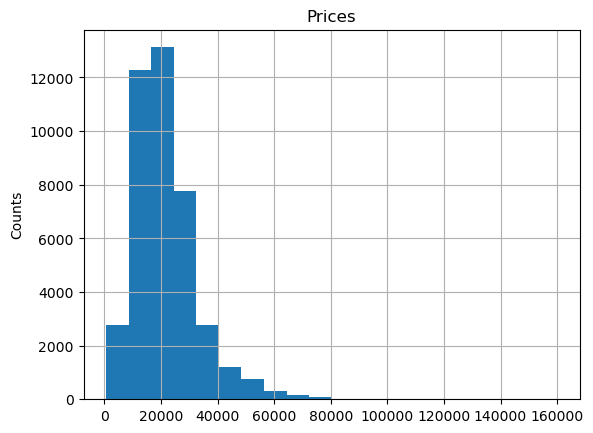

In [4]:
# hist plot of targets
hist_plot_target(y)

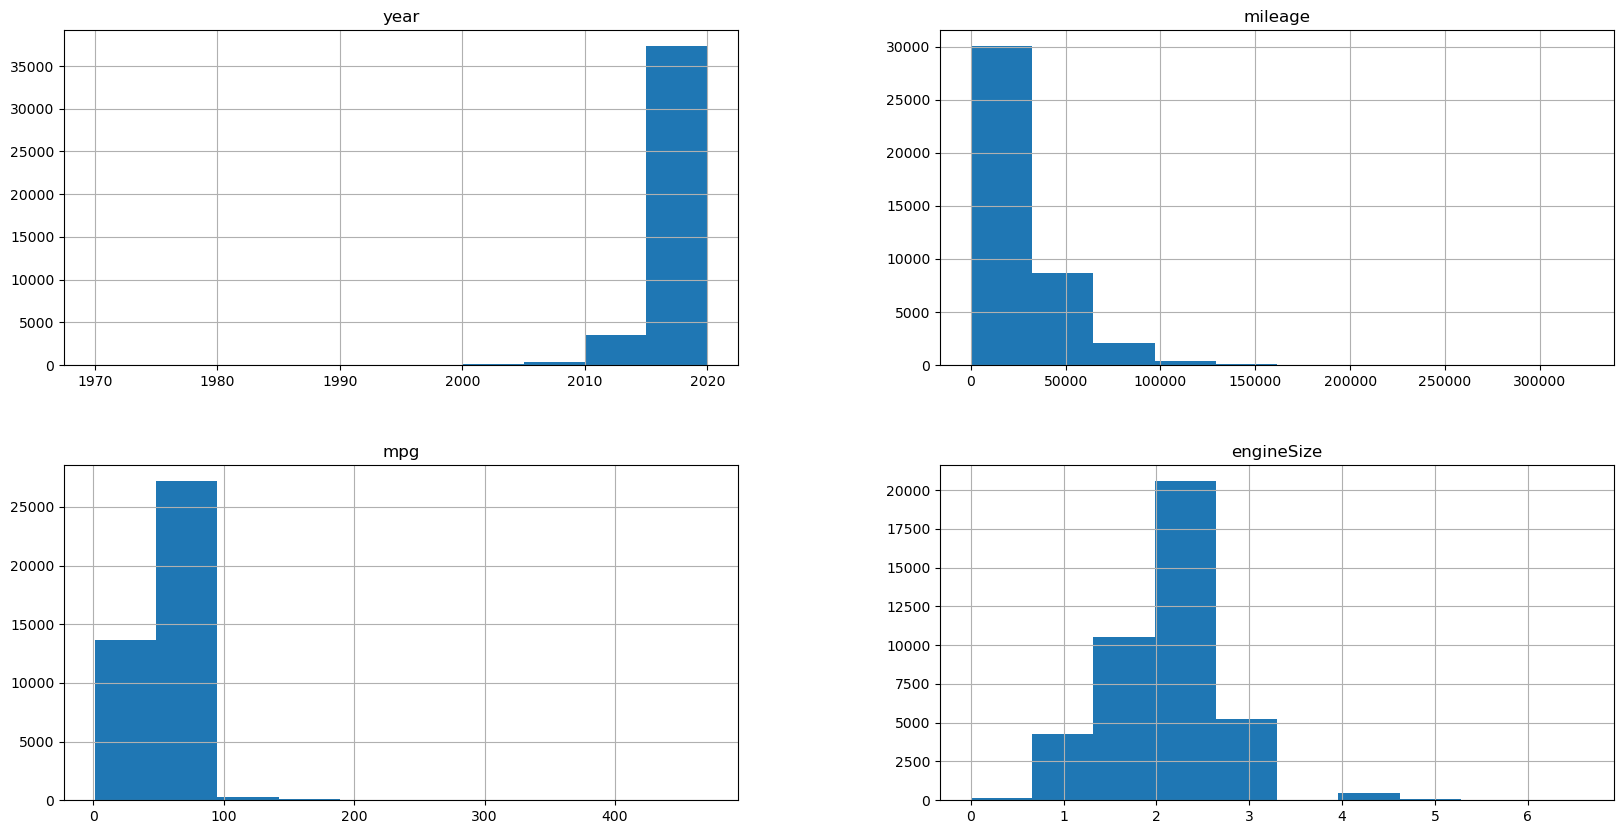

In [5]:
# hist plot of numerical features
hist_plot_numerical(X_pre, features_num)

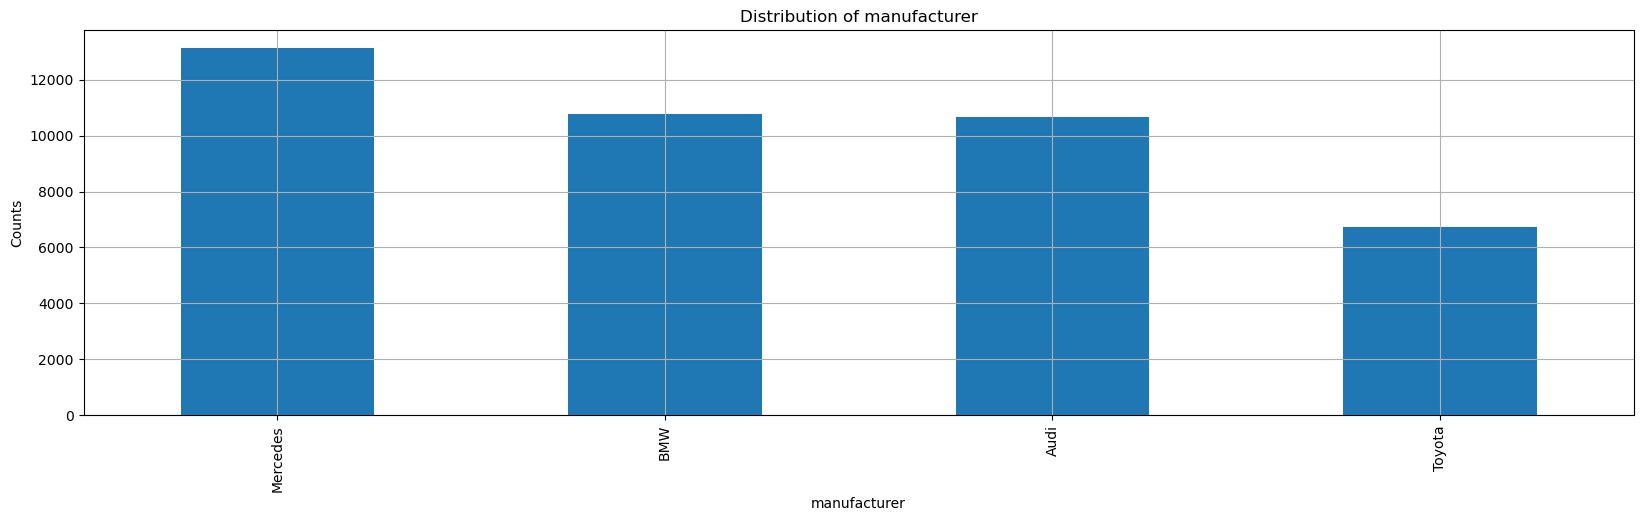

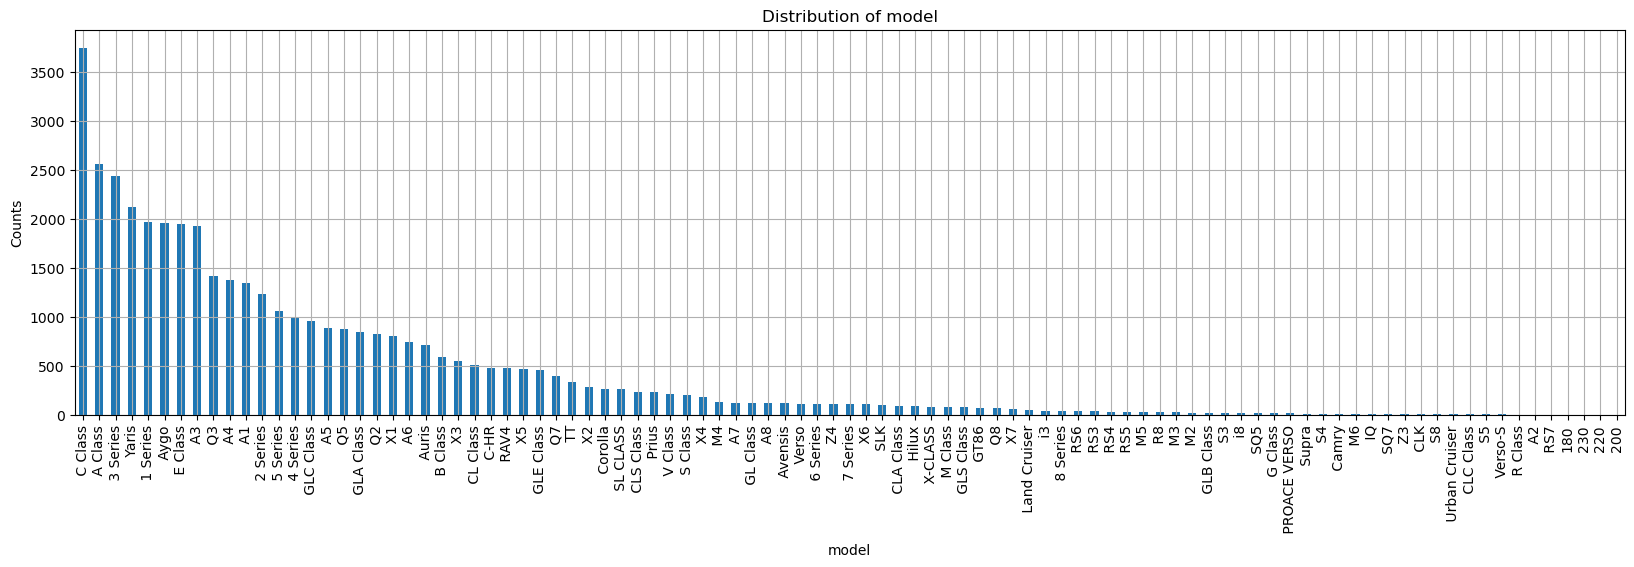

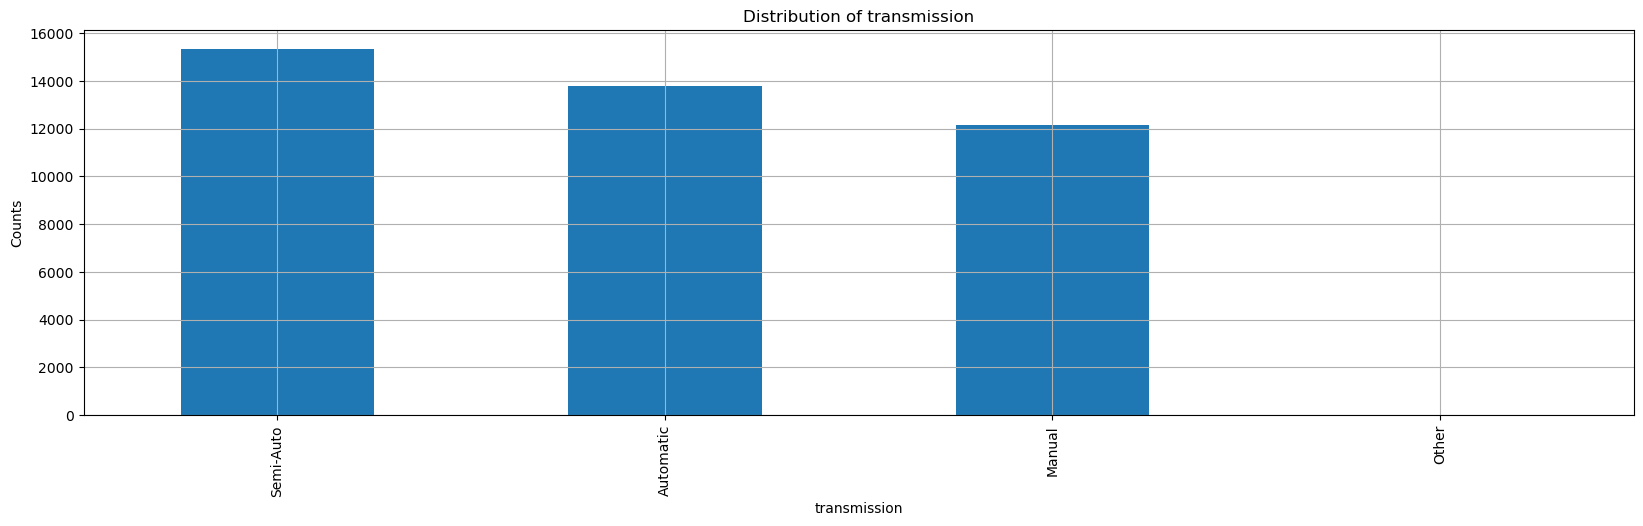

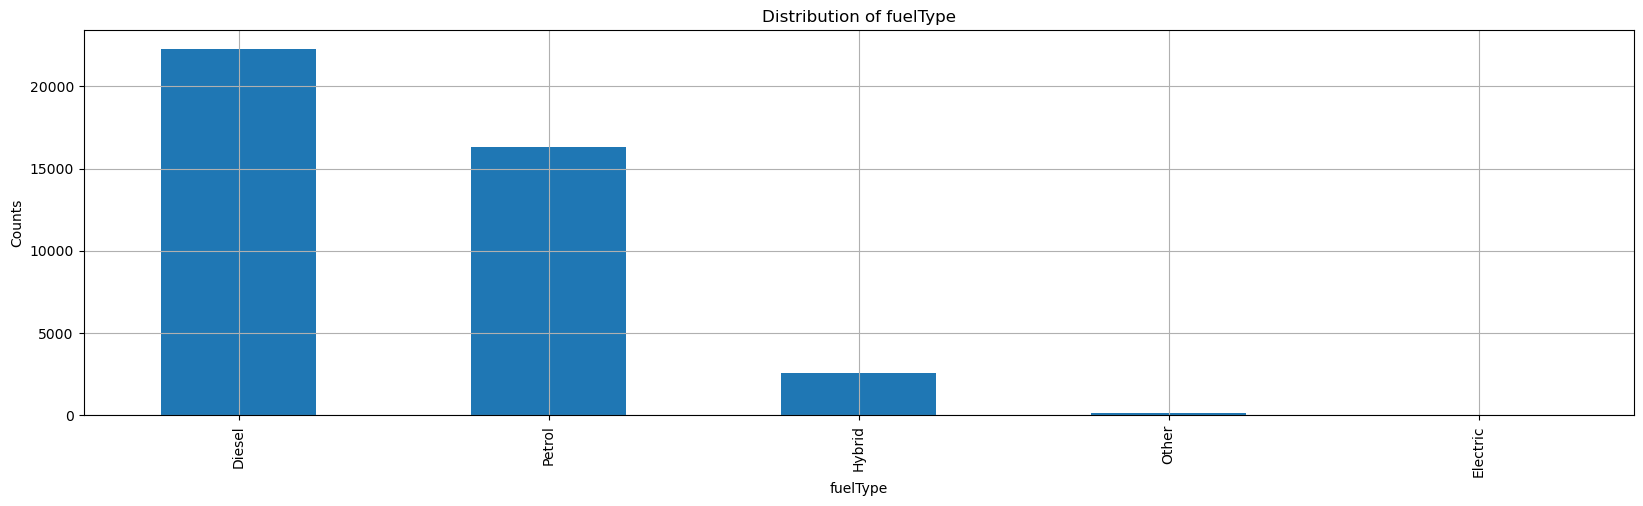

In [6]:
# hist plot of categorical features
hist_plot_categorical(X_pre, features_cat)

In [7]:
# use the OneHotEncoder on categorical features to transform in numerical features
X_cat = X_pre[features_cat]

encoder = OneHotEncoder(handle_unknown = "ignore", sparse_output = False)
X_encoded = pd.DataFrame(encoder.fit_transform(X_cat), columns = encoder.get_feature_names_out(features_cat))
X = pd.concat([X_pre.drop(features_cat, axis = 1), X_encoded], axis = 1)

# get the input size after the One Hot Encoding and compare with the input size before it
input_shape = [X.shape[1]]
print("Input shape before preprocessing: {}".format([X_pre.shape[1]]))
print("Input shape after preprocessing: {}".format(input_shape))

Input shape before preprocessing: [8]
Input shape after preprocessing: [112]


In [8]:
# description of the first samples of the dataset before the One Hot Encoding
X_pre.head()

,manufacturer,model,year,transmission,mileage,fuelType,mpg,engineSize
0,Audi,A1,2017,Manual,15735,Petrol,55.4,1.4
1,Audi,A6,2016,Automatic,36203,Diesel,64.2,2.0
2,Audi,A1,2016,Manual,29946,Petrol,55.4,1.4
3,Audi,A4,2017,Automatic,25952,Diesel,67.3,2.0
4,Audi,A3,2019,Manual,1998,Petrol,49.6,1.0


In [9]:
# description of the first samples of the dataset after the One Hot Encoding
X.head()

,year,mileage,mpg,engineSize,manufacturer_Audi,manufacturer_BMW,manufacturer_Mercedes,manufacturer_Toyota,model_ 1 Series,model_ 2 Series,...,model_230,transmission_Automatic,transmission_Manual,transmission_Other,transmission_Semi-Auto,fuelType_Diesel,fuelType_Electric,fuelType_Hybrid,fuelType_Other,fuelType_Petrol
0,2017,15735,55.4,1.4,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2016,36203,64.2,2.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,2016,29946,55.4,1.4,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,2017,25952,67.3,2.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,2019,1998,49.6,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [10]:
# divide the dataset in training set, validation set and test set
X_train, X_valid_test, y_train, y_valid_test = group_split(X, y, 0.75)
X_valid, X_test, y_valid, y_test = group_split(X_valid_test, y_valid_test, 0.5)

# normalize the dataset to have mean = 0 and variance = 1
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

# Model: Linear Regressor

In [11]:
# linear regressor implemented in keras
model1 = LinearRegression()

# training on training set
model1.fit(X_train, y_train)

LinearRegression()

In [12]:
# evaluate the predictions on the test set
predicted_prices_model1 = model1.predict(X_test)

# evaluate the generalization error on the test set
model1_mae = mean_absolute_error(y_test , predicted_prices_model1)
print("Linear Regression - Test MAE = ", model1_mae)

Linear Regression - Test MAE =  3075.071622212337


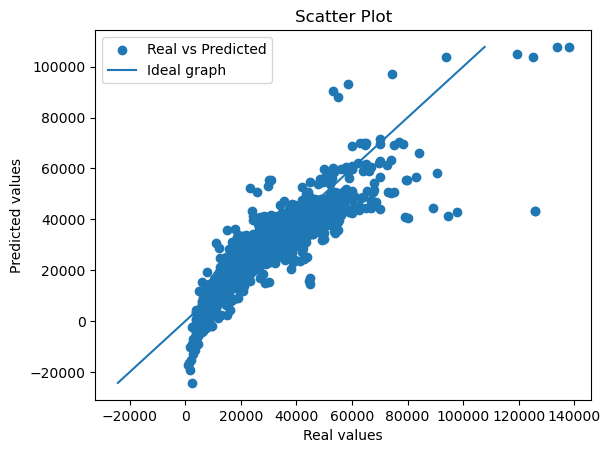

In [13]:
# scatter plot of predictions and real values for model 1
scatter_plot(y_test, predicted_prices_model1)

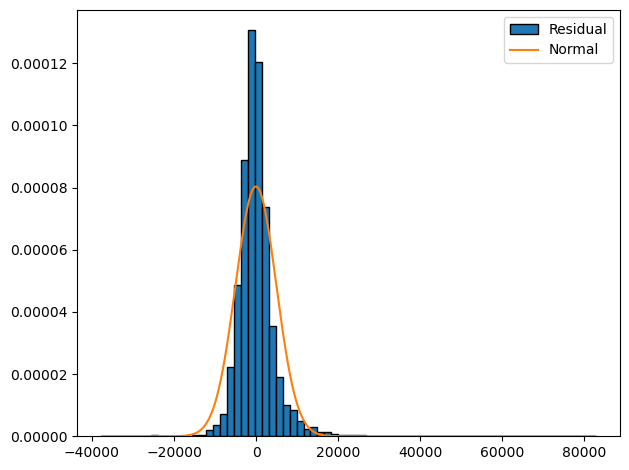

In [14]:
# residual plot for model 1
residual_plot(y_test, predicted_prices_model1)

# Model: Feedforward Neural Network

In [15]:
def build_model(hp):
    model = keras.Sequential()
    
    if hp.Boolean("batch_norm", default = True):
        model.add(keras.layers.BatchNormalization())

    model.add(keras.layers.Dropout(
        hp.Float("dropout", min_value = 0.0, max_value = 0.3, step = 0.1)))
    
    model.add(keras.layers.Dense(
        units = 128,
        input_shape = input_shape,
        kernel_initializer = hp.Choice("initializer", values = ['random_uniform', 'glorot_normal', 'he_normal']),
        kernel_regularizer = regularizers.l2(hp.Choice("l2_regularization", values = [1e-3, 1e-2, 1e-1])),
        activation = "relu"))

    for i in range(hp.Int('num_layers', 1, 3)):
        if hp.Boolean("batch_norm", default = True):
            model.add(keras.layers.BatchNormalization())
        
        model.add(keras.layers.Dropout(
            hp.Float("dropout", min_value = 0.0, max_value = 0.3, step = 0.1)))
        
        model.add(keras.layers.Dense(
            units = hp.Int(f"units_{i}", min_value = 16, max_value = 128, step = 16),
            kernel_initializer = hp.Choice("initializer", values = ['random_uniform', 'glorot_normal', 'he_normal']),
            kernel_regularizer = regularizers.l2(hp.Choice("l2_regularization", values = [1e-3, 1e-2, 1e-1])),
            activation = "relu"))

    if hp.Boolean("batch_norm", default = True):
        model.add(keras.layers.BatchNormalization())
        
    model.add(keras.layers.Dropout(
        hp.Float("dropout", min_value = 0.0, max_value = 0.3, step = 0.1)))
        
    model.add(keras.layers.Dense(
        units = 1,
        kernel_initializer = hp.Choice("initializer", values = ['random_uniform', 'glorot_normal', 'he_normal']),
        kernel_regularizer = regularizers.l2(hp.Choice("l2_regularization", values = [1e-3, 1e-2, 1e-1])),
        activation = "relu"))
    
    model.compile(
        optimizer = "nadam",
        loss = "mae")
    
    return model

In [16]:
# cross validation for finding the best hyperparameters through keras_tuner
tuner = keras_tuner.Hyperband(
    build_model,
    objective = "val_loss",
    max_epochs = 500,
    project_name = "Tuner")

# early stopping for avoiding the overfitting
early_stopping = keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 10)

# cross validation
tuner.search(X_train_scaled, y_train, epochs = 500, validation_data = (X_valid_scaled, y_valid), callbacks = [early_stopping])

Reloading Tuner from .\Tuner\tuner0.json


In [17]:
# model created with the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters()[0]
model2 = tuner.hypermodel.build(best_hyperparameters)

Epoch 1/500

969/969 [==============================] - 3s 2ms/step - loss: 4451.1753 - val_loss: 2415.0137
Epoch 2/500
969/969 [==============================] - 1s 1ms/step - loss: 2139.0378 - val_loss: 2133.6868
Epoch 3/500
969/969 [==============================] - 1s 1ms/step - loss: 2046.4067 - val_loss: 2002.6113
Epoch 4/500
969/969 [==============================] - 2s 2ms/step - loss: 1981.2772 - val_loss: 1958.8950
Epoch 5/500
969/969 [==============================] - 2s 2ms/step - loss: 1940.8997 - val_loss: 1903.5942
Epoch 6/500
969/969 [==============================] - 2s 2ms/step - loss: 1912.5901 - val_loss: 1912.8042
Epoch 7/500
969/969 [==============================] - 1s 1ms/step - loss: 1896.0917 - val_loss: 1919.9832
Epoch 8/500
969/969 [==============================] - 2s 2ms/step - loss: 1874.6635 - val_loss: 1968.7035
Epoch 9/500
969/969 [==============================] - 2s 2ms/step - loss: 1856.8225 - val_loss: 1833.1713
Epoch 10/500
969/969 [==============

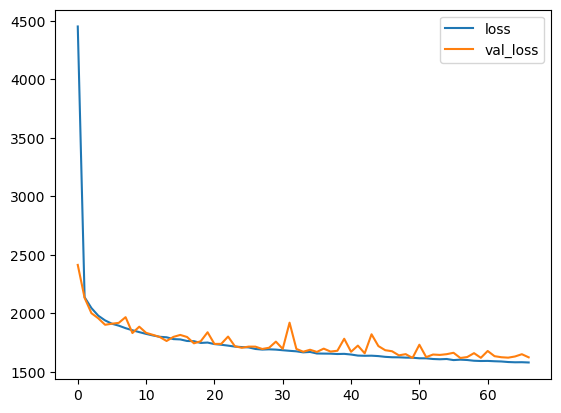

In [18]:
# training on training set
history = model2.fit(X_train_scaled, y_train, epochs = 500, batch_size = 32, validation_data  = (X_valid_scaled, y_valid), callbacks = [early_stopping])

# training plot
history_df = pd.DataFrame(history.history)
history_df.loc[:, ["loss", "val_loss"]].plot()
print("Minimum Loss: {:0.4f}".format(history_df["loss"].min()))
print("Minimum Validation Loss: {:0.4f}".format(history_df["val_loss"].min()))

In [19]:
# evaluate the predictions on the test set
predicted_prices_model2 = model2.predict(X_test_scaled)

# evaluate the generalization error on the test set
model2_mae = mean_absolute_error(y_test , predicted_prices_model2)
print("Feedforward Neural Network - Test MAE = ", model2_mae)

162/162 [==============================] - 0s 858us/step
Feedforward Neural Network - Test MAE =  1654.5896968117618


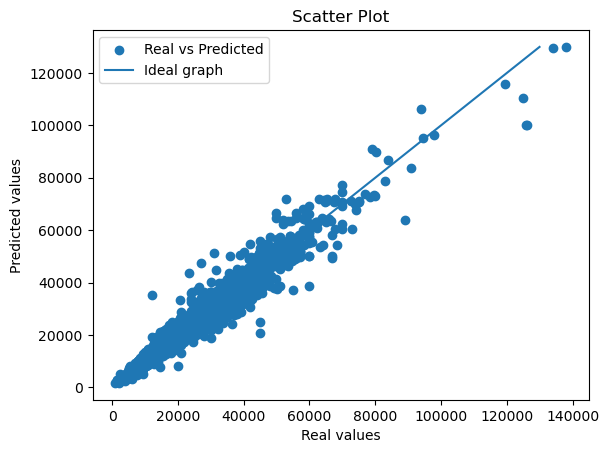

In [20]:
# scatter plot of predictions and real values for model 2
scatter_plot(y_test, predicted_prices_model2)

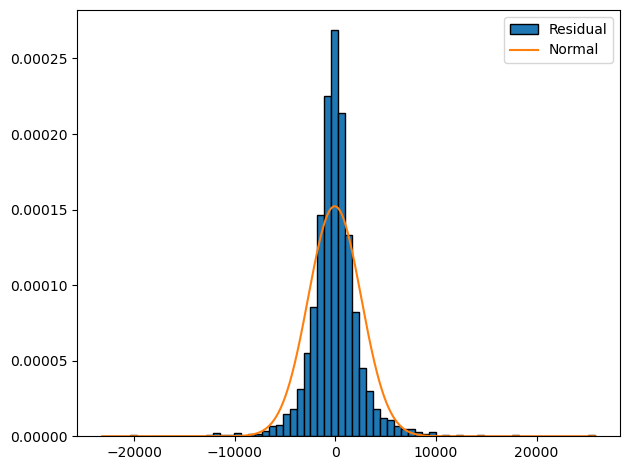

In [21]:
# residual plot for model 2
residual_plot(y_test, predicted_prices_model2.flatten())

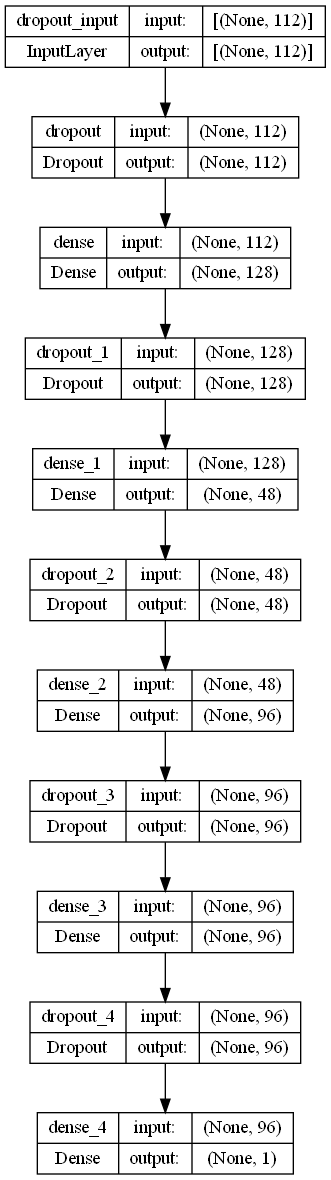

In [22]:
# plot the structure of the Feedforward Neural Network
plot_model(model2, show_shapes = True)